*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<img style="padding: 10px; float:right;" alt="CC-BY-SA icon.svg in public domain" src="https://upload.wikimedia.org/wikipedia/commons/d/d0/CC-BY-SA_icon.svg" width="125">


<a href="https://colab.research.google.com/github//asabenhur/CS345/blob/master/notebooks/module03_04_linear_regression_gradient_descent.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%autosave 0

Autosave disabled


# Solving linear regression using gradient descent

In this notebook we finally derive an algorithm for solving linear regression, i.e. finding parameters $\mathbf{w}$ that minimize

$$
J(\mathbf{w}) = \frac{1}{N}\sum_{i=1}^N(y_i-\hat{y}_i)^2 = \frac{1}{N}\sum_{i=1}^N(y_i - \mathbf{w}^\top \mathbf{x}_i)^2 .
$$

For simplicity, we are ignoring the bias term $b$.

Rather than finding the maximum or minimum of a function of a single variable our task is to find the minimum of a function of multiple variables.  A good way to think about the problem is in terms of a topographic map:

<img style="padding: 10px; float:center;" alt=" Creative Commons Attribution-Share Alike 3.0 Unported" src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Hawaii_gmt_de.jpg" width="600">

To do so, we will apply what we learned about partial derivatives to solve linear regression.  But first, we need another concept, namely that of the gradient.

### The gradient

For a function of two variables, $f(x_1,x_2)$, the gradient is a two-dimensional vector consisting of the derivatives of the function with respect to its variables $x_1$ and $x_2$:

$$\nabla f(x_1,x_2) =  
\begin{pmatrix}
\frac{\partial f(x_1,x_2)}{\partial x_1} \\ 
\frac{\partial f(x_1,x_2)}{\partial x_2}. 
\end{pmatrix}$$


For a general multivariate function $f(x_1,\ldots,x_d)$ it is simply the vector of partial derivatives.

$$\nabla f(x_1,\ldots, x_d) =  
\begin{pmatrix}
\frac{\partial f(x_1,\ldots,x_d)}{\partial x_1} \\
\vdots \\
\frac{\partial f(x_1,\ldots,x_d)}{\partial x_d}. 
\end{pmatrix}$$


An alternative notation to $\nabla f$ is $\frac{\partial f}{\partial \mathbf{x}}$.  

**Example**

For the function $f(x_1, x_2) = x_1^2 + x_2^2$ we have

$$\nabla f(x_1,x_2) =  
\begin{pmatrix}
\frac{\partial f(x_1,x_2)}{\partial x_1} \\ 
\frac{\partial f(x_1,x_2)}{\partial x_1} 
\end{pmatrix} = 
\begin{pmatrix}2x_1 \\ 2x_2 \end{pmatrix} $$

The $\nabla$ symbol, is a shorthad for the vector of partial derivatives, which is also called the **gradient**.

The following figure shows contours of the function $f$ we just looked at, along with the direction of the gradient.  It should give us the intuition that the gradient points in the direction of steepest increase of the function.  Notice that the gradient is perpendicular to the contours of constant function value.
Also notice that the gradient tends to zero as we approach the minimum of the function at the origin.

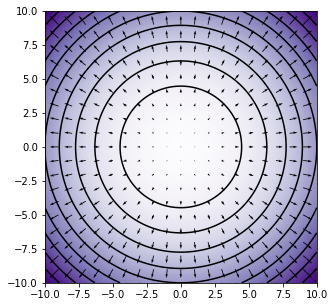

In [4]:

def f(x, y) :
    return x**2 + y**2

x = np.arange(-10, 10, 1)
y = np.arange(-10, 10, 1)

x_dense = np.linspace(-10, 10, 500)
y_dense = np.linspace(-10, 10, 500)

X, Y = np.meshgrid(x_dense, y_dense)
U, V = np.meshgrid(2*x, 2*y)

Z = f(X, Y)

plt.figure(figsize=(5,5))
C = plt.contour(x_dense, y_dense, Z, 10, colors='black')

q = plt.quiver(x, y, U, V)

im = plt.imshow(Z, origin='lower',
                cmap=plt.cm.Purples, extent=(-10,10,-10,10) )


### Practice with gradients

Let's practice with taking gradients of multivariate functions.
We'll start with the dot product.  We will take the gradient with respect to the parameters $\mathbf{w}$.

$$
f(\mathbf{w}) = \mathbf{w}^\top \mathbf{x} = \sum_{i=1}^d w_i x_i.
$$

We are interested in the dependence of this function on $\mathbf{w}$, because these are the parameters we are seeking to optimize.  The $\mathbf{x}$'s are constant in this case.  This is an easy case:

$$
\frac{\partial f}{\partial w_i} = x_i .
$$

We can thus conclude that 

$$
\nabla_{\mathbf{w}} f(\mathbf{w}) = \mathbf{x} .
$$

Here we used the notation $\nabla_{\mathbf{w}}$ to denote that the gradient is with respect to $\mathbf{w}$.
In our alternative notation, we can write this as
$
\frac{\partial f}{\partial \mathbf{w}} = \mathbf{x} .
$


### The gradient for linear regression

The mean-squared-error is our cost function for linear regression:

$$
J(\mathbf{w}) = \frac{1}{N}\sum_{i=1}^N(y_i-\hat{y}_i)^2 = \frac{1}{N}\sum_{i=1}^N(y_i - \mathbf{w}^\top \mathbf{x}_i)^2 .
$$

For simplicity, we are ignoring the bias term $b$.  Before taking the gradient, we'll express it as:

$$
J(\mathbf{w}) = \frac{1}{N}\sum_{i=1}^N \left( y_i^2 - 2y_i \mathbf{w}^\top \mathbf{x} + (\mathbf{w}^\top \mathbf{x}_i)^2 \right) .
$$

Now for the gradient:

\begin{equation}
\begin{split}
\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}} & = 
\frac{1}{N}\sum_{i=1}^N \left( - 2y_i \mathbf{x} + 2(\mathbf{w}^\top \mathbf{x})\mathbf{x}_i \right) \\
 & = -\frac{1}{N}\sum_{i=1}^N 2 \left( y_i - \mathbf{w}^\top \mathbf{x}_i\right) \mathbf{x}_i  .
\end{split}
\end{equation}



### Gradient descent

In the same way we were able to find the minimum of a univariate function using derivatives, we can find the minimum of a multi-dimensional surface by following the gradient.  This process is called **gradient descent**, and is described next.

Given a function $J(\mathbf{w})$, the gradient is the direction of steepest ascent.
Therefore to minimize $J(\mathbf{w})$, we iteratively take small steps in the direction of the negative of the gradient.


Gradient descent is an iterative algorithm as follows:

* Initialize $\mathbf{w}(0),\eta$
* for $t = 0,1,\ldots$
  * $\mathbf{w}(t+1) = \mathbf{w}(t) - \eta \frac{\partial J}{\partial \mathbf{w}}$
  * if converged, break
  
The halting condition for the algorithm can be specified in terms of the number of epochs like we did for the perceptron, or in terms of convergence of the loss function (the mean-squared-error).  In other words, if there is little change of the loss function across epochs.

### Questions:

* How would you need to modify the algorithm to find a local maximum?

* Can you guarantee the algorithm would find a global minimum/maximum?

* Find the gradient when we have a bias $b$.


### Linear regression using gradient descent

We are now ready to implement linear regression using gradient descent, and apply it to the advertising data.

In [4]:
data = pd.read_csv('http://faculty.marshall.usc.edu/gareth-james/ISL/Advertising.csv', index_col=0)
X = data[['TV', 'radio']].values
y = data['sales'].values
X.shape, y.shape

((200, 2), (200,))

In [58]:
class linear_regression :
    def __init__(self, learning_rate=0.00001, 
                 bias_learning_rate=0.01, epochs=1000) :
        self.learning_rate = learning_rate
        self.bias_learning_rate = bias_learning_rate
        self.epochs = epochs

    def compute_loss(self, X, y):
        squared_errors = np.power((self.predict(X) - y), 2)
        return np.sum(squared_errors) / len(X)
  
    def predict(self, X) :
        return X @ self.w + self.b
                              
    def fit(self, X, y):
        self.w = np.zeros( (X.shape[1]), np.float)
        self.b = 0.0
        # self.cost stores a history of the loss function values
        self.loss = []#np.zeros(self.iterations,np.float)
        for i in range(self.epochs):
            y_pred = self.predict(X)
            # compute individual gradients and then average them:
            gradients_w = np.array([-2*(y[i]-y_pred[i])*X[i] 
                                    for i in range(len(X))])
            gradient_w = np.mean(gradients_w, axis=0)
            # updating w with the gradient
            #print(gradient_w.shape)
            self.w = self.w - self.learning_rate * gradient_w
            gradient_b = - 2 * np.mean( (y - y_pred) )
            #gradients_b = [-2*(y[i]-y_pred[i]) for i in range(len(X))]
            #gradient_b = np.sum(gradients_b) / len(X)
            # updating b with the gradient:
            self.b = self.b - self.bias_learning_rate * gradient_b

            self.loss.append(self.compute_loss(X, y))


In [59]:
linreg = linear_regression()
linreg.fit(X, y)

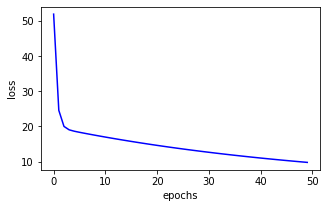

In [61]:
plt.figure(figsize=(5,3))
plt.plot(linreg.loss[:50], 'b')
plt.xlabel('epochs')
plt.ylabel('loss');

Let's compare the learned parameters with the solution using the scikit-learn implementation:

In [64]:
from sklearn.linear_model import LinearRegression

# instantiate and fit
linreg_sklearn = LinearRegression()
linreg_sklearn.fit(X, y)

# print the coefficients
print (linreg_sklearn.coef_, linreg_sklearn.intercept_)
print (linreg.w, linreg.b)

[0.04575482 0.18799423] 2.9210999124051362
[0.04552492 0.18527279] 3.030795322196597
